In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# Load dataset
file_path = '../data.csv'
dataset = pd.read_csv(file_path)

# Basic info
print(dataset.head())
print(dataset.info())

# Handling missing values
if dataset.isnull().sum().any():
    dataset = dataset.fillna(dataset.mean())

# Removing outliers in 'age'
if 'age' in dataset.columns:
    dataset = dataset[dataset['age'] < 100]

# Feature Engineering
trait_columns = {
    "Extraversion": ["E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8", "E9", "E10"],
    "Neuroticism": ["N1", "N2", "N3", "N4", "N5", "N6", "N7", "N8", "N9", "N10"],
    "Agreeableness": ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10"],
    "Conscientiousness": ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10"],
    "Openness": ["O1", "O2", "O3", "O4", "O5", "O6", "O7", "O8", "O9", "O10"],
}

# Check for missing trait columns
missing_columns = [col for trait in trait_columns.values() for col in trait if col not in dataset.columns]
if missing_columns:
    raise ValueError(f"Dataset is missing required columns: {missing_columns}")

# Compute personality traits as mean of respective questions
for trait, cols in trait_columns.items():
    dataset[trait] = dataset[cols].mean(axis=1)

# Feature selection
X = dataset.iloc[:, 3:53].values  # Main features

# Include categorical features
if {"age", "gender", "hand"}.issubset(dataset.columns):
    X = np.hstack((X, dataset[["age", "gender", "hand"]].values))

y = dataset[list(trait_columns.keys())].values  # Target variables

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

   age  gender  hand  E1  E2  E3  E4  E5  E6  E7  ...  O1  O2  O3  O4  O5  O6  \
0   53       1     1   4   2   5   2   5   1   4  ...   4   1   3   1   5   1   
1   46       2     1   2   2   3   3   3   3   1  ...   3   3   3   3   2   3   
2   14       2     1   5   1   1   4   5   1   1  ...   4   5   5   1   5   1   
3   19       2     1   2   5   2   4   3   4   3  ...   4   3   5   2   4   2   
4   25       2     1   3   1   3   3   3   1   3  ...   3   1   1   1   3   1   

   O7  O8  O9  O10  
0   4   2   5    5  
1   3   1   3    2  
2   5   5   5    5  
3   5   2   5    5  
4   3   1   5    3  

[5 rows x 53 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19719 entries, 0 to 19718
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     19719 non-null  int64
 1   gender  19719 non-null  int64
 2   hand    19719 non-null  int64
 3   E1      19719 non-null  int64
 4   E2      19719 non-null  int64
 5   E3   

In [41]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf) * 100

print(f"Random Forest R² Score: {rf_r2:.4f}")


Random Forest R² Score: 57.5657


In [42]:
xgb_model = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, n_estimators=400, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, y_pred_xgb) * 100

print(f"XGBoost R² Score: {xgb_r2:.4f}")


XGBoost R² Score: 99.3207


In [43]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_mlp = mlp_model.predict(X_test)
mlp_r2 = r2_score(y_test, y_pred_mlp) * 100

print(f"MLP Neural Network R² Score: {mlp_r2:.4f}")


MLP Neural Network R² Score: 99.2999


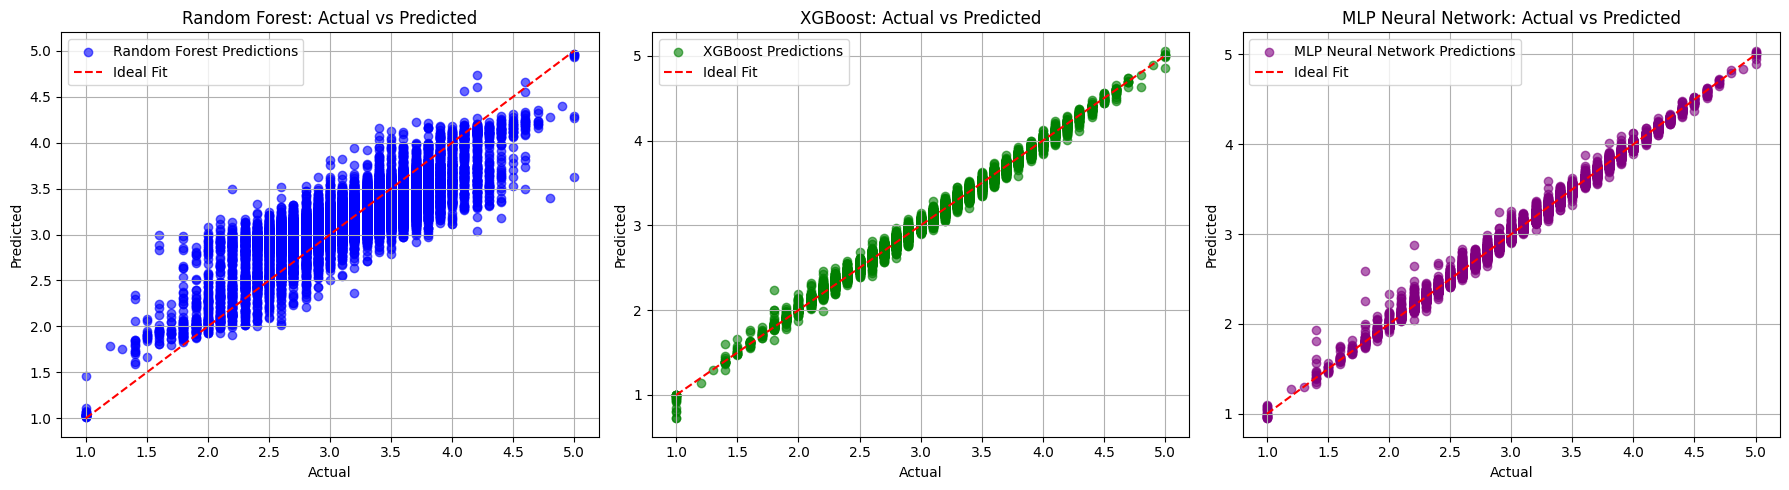

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Store models and predictions in a dictionary
models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'MLP Neural Network': mlp_model
}

colors = ['blue', 'green', 'purple']  # Colors for the scatter plots

plt.figure(figsize=(18, 5))

for i, (model_name, model) in enumerate(models.items()):
    plt.subplot(1, len(models), i + 1)
    
    # Get predictions
    y_pred = model.predict(X_test)

    # Scatter plot of actual vs predicted
    plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.6, color=colors[i], label=f'{model_name} Predictions')
    
    # Ideal Fit line (diagonal reference line)
    plt.plot([min(y_test.flatten()), max(y_test.flatten())], 
             [min(y_test.flatten()), max(y_test.flatten())], 
             color='red', linestyle='--', label='Ideal Fit')

    # Titles and labels
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
